In [1]:
# --- Standard libraries
import heapq as hq
# --- PyTorch
import torch
import lightning as L
# --- RDKit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
# --- Bokeh
from bokeh.io import output_notebook, show, export_svg
from bokeh.models import Label
from bokeh.layouts import row
output_notebook()
# --- Science python
from sklearn.metrics import root_mean_squared_error
from scipy.stats import wasserstein_distance, spearmanr
# --- Modules from local files
from GNN import QM9_GNN
from utils.utils import bokeh_spectra, calculate_rse, bokeh_hist, get_spec_prediction

Loading BokehJS ...

In [2]:
# --- Define GNN properties
num_tasks = 300
num_layers = 5
in_channels = [10, 60, 60, 60, 60]
out_channels = [60, 60, 60, 60, 300]
gnn_type = 'gcn'
heads = 1
drop_ratio = 0.0
graph_pooling = 'mean'

In [3]:
model = QM9_GNN(
    num_tasks,
    num_layers,
    in_channels,
    out_channels,
    gnn_type,
    heads,
    drop_ratio,
    graph_pooling,
)
device = "cpu"
model = model.to(device)

In [4]:
checkpoint = './ML_models/lightning_logs/version_3/checkpoints/epoch=299-step=679500.ckpt'
hparam = './ML_models/lightning_logs/version_3/hparams.yaml'

model = QM9_GNN.load_from_checkpoint(checkpoint, hparams_file=hparam)

In [5]:
test_dataset = torch.load("./processed/test_version3_charge_hot_num.pt")
# --- Show details of the dataset
print(test_dataset)
print('-----------')
print(f'Number of graphs: {len(test_dataset)}')
print(f'Number of features: {test_dataset.num_features}')
print(f'Number of classes: {test_dataset.num_classes}')
print('')
# --- Show details of the first molecule/graph in the dataset
data = test_dataset[6]
print(data)
print('-----------')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_directed()}')

/tmp/ipykernel_7920/3801455418.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_dataset = torch.load("./processed/test_version3_charge_hot_num.pt")


XASDataset(6292)
-----------
Number of graphs: 6292
Number of features: 10
Number of classes: 0

Data(x=[9, 10], edge_index=[2, 20], edge_attr=[20, 4], spectrum=[300], idx=[1], smiles='CC1=NC[C@@H]2C(=O)CN12')
-----------
Number of nodes: 9
Number of edges: 20
Average node degree: 2.22
Has isolated nodes: False
Has self loops: False
Is undirected: False


In [6]:
# --- Create empty dictionary to contain spectra
pred = {}
tru = {}

# --- Loop over all molecules in test dateset and assign to dictionary index
for index in range(len(test_dataset)):
    pred[index], tru[index] = get_spec_prediction(model, index, test_dataset, device)

# --- Parse spectra into dictionary
model_dict = [pred, tru]

# # --- Save prediction results to file
# with open("ML_models/results/" + model_name, "wb") as file:
#     pkl.dump(model_dict, file)
    
# --- Get 
predict = model_dict[0]
true = model_dict[1]

In [7]:
wasser = []
mse = []
rse = []
spear = []

for x in range(len(predict)):
    # Wasserstein metric
    wass_temp = wasserstein_distance(true[x], predict[x])
    wasser.append(wass_temp)
    # Mean squared error
    mse_temp = root_mean_squared_error(true[x], predict[x])
    mse.append(mse_temp)
    # RSE
    rse_temp = calculate_rse(true[x], predict[x])
    rse.append(rse_temp)
    # Spearman coefficient
    spear_temp = spearmanr(true[x], predict[x])
    spear.append(spear_temp[0])

ave_wasser = sum(wasser) / len(wasser)
ave_spear = sum(spear) / len(spear)
ave_mse = sum(mse) / len(mse)
ave_rse = sum(rse) / len(rse)

print(f"Average Wasserstein distance = {ave_wasser}")
print(f'Average spearman correlation coefficient = {ave_spear}')
print(f"Average Root MSE = {ave_mse}")
print(f'Average RSE = {ave_rse}')

Average Wasserstein distance = 0.028470712642983294
Average spearman correlation coefficient = 0.7408728532243282
Average Root MSE = 0.0715525895357132
Average RSE = 0.07206196337938309


In [8]:
rank_rse = hq.nsmallest(6292, rse)

rank_graph = []

for x in range(6292):
    rank_idx = rse.index(rank_rse[x])
    rank_graph.append(rank_idx)

print('The 5 best RSE values are:')
for x in range(5):
    print(f'RSE = {rank_rse[x]:.3f}, graph number = {rank_graph[x]}')

print('')
print('The 5 worst RSE values are:')
for x in range(-1, -6, -1):
    print(f'RSE = {rank_rse[x]:.3f}, graph number = {rank_graph[x]}')

The 5 best RSE values are:
RSE = 0.024, graph number = 670
RSE = 0.025, graph number = 695
RSE = 0.025, graph number = 5844
RSE = 0.027, graph number = 3064
RSE = 0.027, graph number = 3602

The 5 worst RSE values are:
RSE = 0.238, graph number = 663
RSE = 0.224, graph number = 4524
RSE = 0.218, graph number = 4292
RSE = 0.201, graph number = 820
RSE = 0.201, graph number = 2206


In [9]:
# --- Plot best spectra prediction
p1 = bokeh_spectra(predict[rank_graph[0]], true[rank_graph[0]])
p2 = bokeh_spectra(predict[rank_graph[1]], true[rank_graph[1]])
p3 = bokeh_spectra(predict[rank_graph[2]], true[rank_graph[2]])
p = row(p1, p2, p3)
show(p)

In [10]:
# --- Plot worst spectra prediction
p1 = bokeh_spectra(predict[rank_graph[-1]], true[rank_graph[-1]])
p2 = bokeh_spectra(predict[rank_graph[-2]], true[rank_graph[-2]])
p3 = bokeh_spectra(predict[rank_graph[-3]], true[rank_graph[-3]])
p = row(p1, p2, p3)
show(p)

In [11]:
test_dataset[663]

Data(x=[9, 10], edge_index=[2, 16], edge_attr=[16, 4], spectrum=[300], idx=[1], smiles='C[NH2+]CC[C-](C#N)C#N')

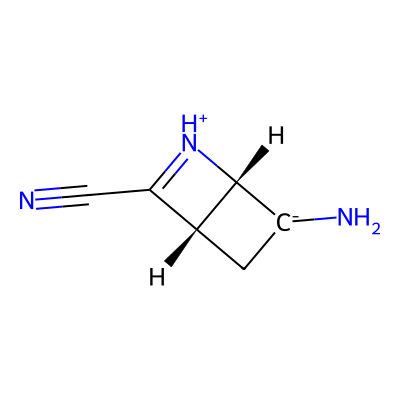

In [14]:
# --- View molecule using RDKit
IPythonConsole.molSize = 400, 400
mol = Chem.MolFromSmiles(test_dataset[2206].smiles)
mol